# Reset variables

In [105]:
%reset -f

# Variables

In [106]:
datasets = {
    "preop": {
        "filename_input": "data/ct_scan_knee_preop.npy",
        "filename_output_nrrd": "data/ct_scan_knee_preop.nrrd",
        "min_hu": -1000,
        "max_hu": 3200
    },
    "postop": {
        "filename_input": "data/ct_scan_knee_postop.npy",
        "filename_output_nrrd": "data/ct_scan_knee_postop.nrrd",
        "min_hu": -1000,
        "max_hu": 3200
    }
}

# Choose dataset
dataset_name = "preop"  # Change to "preop" to switch datasets

# Load selected dataset
filename_input = datasets[dataset_name]["filename_input"]
filename_output_nrrd = datasets[dataset_name]["filename_output_nrrd"]
min_hu = datasets[dataset_name]["min_hu"]
max_hu = datasets[dataset_name]["max_hu"]

print(f"Using {dataset_name} dataset: {filename_input} -> {filename_output_nrrd}")

filename_stent_nrrd = 'data/stent.nrrd'

Using preop dataset: data/ct_scan_knee_preop.npy -> data/ct_scan_knee_preop.nrrd


# Processing the data

We now have a .npy file with HU values, the next steps is to process and visualize the data. First lets examine the scan dimensions

In [107]:
import numpy as np
ct_data = np.load(filename_input)

# Print the shape of the numpy array (dimensions)
print(f"Shape of the CT data: {ct_data.shape}")

# Assuming the resolution in all directions is 0.6mm (as per your input)
resolution_mm = 0.6

# Calculate the physical dimensions in mm
depth_mm = ct_data.shape[0] * resolution_mm  # Depth (Z axis)
height_mm = ct_data.shape[1] * resolution_mm  # Height (Y axis)
width_mm = ct_data.shape[2] * resolution_mm   # Width (X axis)

print(f"Physical dimensions of the scanned area (mm):")
print(f"  Depth: {depth_mm:.2f} mm")
print(f"  Height: {height_mm:.2f} mm")
print(f"  Width: {width_mm:.2f} mm")



Shape of the CT data: (1003, 512, 512)
Physical dimensions of the scanned area (mm):
  Depth: 601.80 mm
  Height: 307.20 mm
  Width: 307.20 mm


# Inspecting the HU Values

Hounsfield Units (HU) represent the density of materials in CT imaging. Common HU values include:

- Air: ~-1000 HU. This is empty space around the knee joint.
- Water: 0 HU
- Bone: +300 to +1000 HU (or higher, depending on the density)
- Titanium: 2,921±218 HU. 

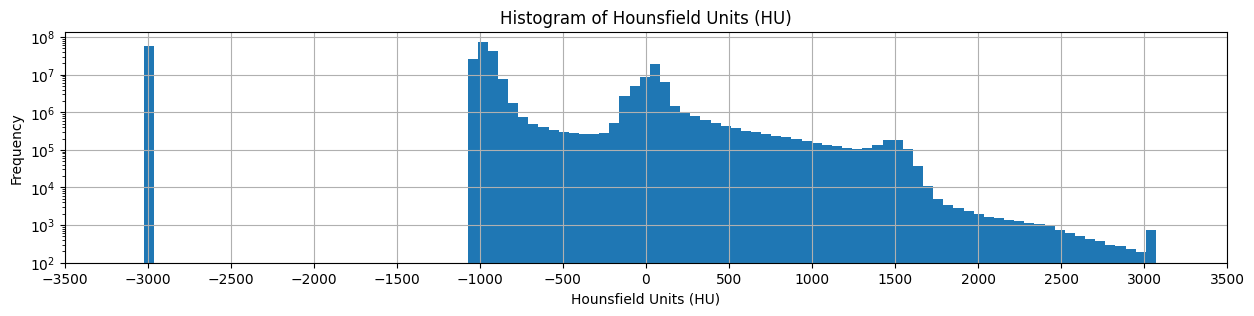

Min HU: -3024, Max HU: 3071


In [108]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram(ct_data, name, tick_interval=None, log_scale=True):
    """
    Plots a histogram of the flattened CT data.

    Parameters:
    - ct_data: 3D numpy array representing the CT data.
    - name: String to be used in the histogram title.
    - tick_interval: The interval between x-axis ticks (optional).
    - log_scale: Boolean to set y-axis to logarithmic scale (default is True).
    """
    # Flatten the 3D data into a 1D array
    flat_ct_data = ct_data.flatten()

    # Plot the histogram
    plt.figure(figsize=(15, 3))
    plt.hist(flat_ct_data, bins=100)
    plt.title(f'Histogram of {name}')
    plt.xlabel(name)
    plt.ylabel('Frequency')
    plt.grid(True)

    # Set y-axis to logarithmic scale if specified
    if log_scale:
        plt.yscale('log')

    # Set x ticks based on tick_interval if specified
    if tick_interval is not None:
        start_tick = np.floor(flat_ct_data.min() / tick_interval) * tick_interval
        end_tick = np.ceil(flat_ct_data.max() / tick_interval) * tick_interval
        ticks = np.arange(start_tick, end_tick + tick_interval, tick_interval)
        plt.xticks(ticks=ticks)
    
    plt.show()

   

# Call the function with parameters ct_data and name
plot_histogram(ct_data, "Hounsfield Units (HU)", 500)

# Print min and max HU values 
print(f"Min HU: {ct_data.min()}, Max HU: {ct_data.max()}")

**Note**: The peak around -3000 HU is likely scan artifacts or noise, often from metal implants.

# Normalizing HU values 

For color mapping with three js we need to normalize these values to [0, 1]. 

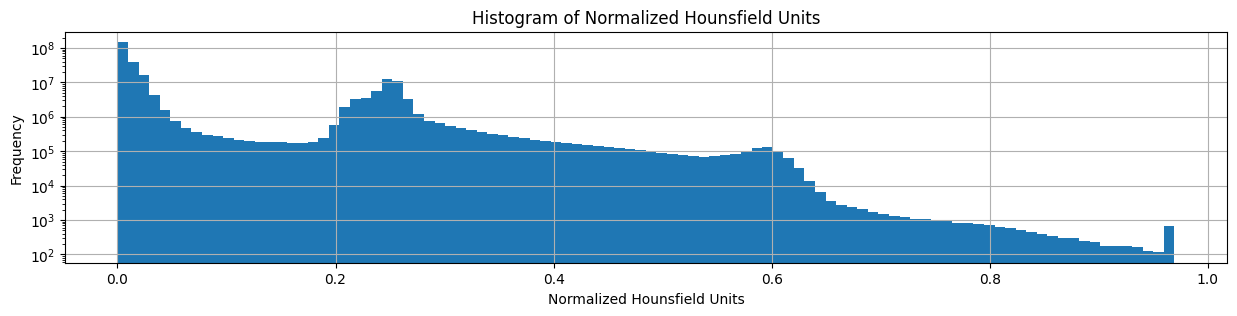

In [109]:
def clip_and_normalize(ct_data, min_val, max_val):
    """
    Clips and normalizes the CT data.

    Parameters:
    - ct_data: 3D numpy array representing the CT data.
    - min_val: Minimum value for clipping.
    - max_val: Maximum value for clipping.

    Returns:
    - ct_data_normalized: The normalized CT data.
    """
    # Clip HU values to the specified range
    ct_data_clipped = np.clip(ct_data, min_val, max_val)

    # Normalize the clipped data to the range [0, 1]
    ct_data_normalized = (ct_data_clipped - min_val) / (max_val - min_val)

    # Cast to float32 (Three.js expects float data)
    ct_data_normalized = ct_data_normalized.astype(np.float32)

    return ct_data_normalized

# Clip and normalize the data
ct_data_normalized = clip_and_normalize(ct_data, min_hu, max_hu)

# Plot the histogram of the normalized data
plot_histogram(ct_data_normalized, "Normalized Hounsfield Units")


# Subsample result to reduce file size

You need ``pip install scipy``

In [110]:
import numpy as np
from scipy.ndimage import gaussian_filter

def filter_and_subsample(ct_data, subsampling_factor=2, sigma=1):
    """
    Applies a Gaussian filter to the normalized CT data and then subsamples it.
    
    Parameters:
    - ct_data_normalized: The normalized CT data (3D numpy array).
    - subsampling_factor: The factor by which to downsample the data.
    - sigma: Standard deviation for Gaussian kernel.
    
    Returns:
    - ct_data_scaled: The filtered and downsampled data.
    """
    # Apply Gaussian filter
    filtered_data = gaussian_filter(ct_data, sigma=sigma)

    # Downsample by selecting every n-th voxel
    ct_data_scaled = filtered_data[::subsampling_factor, ::subsampling_factor, ::subsampling_factor]

    return ct_data_scaled

# Usage example
ct_data_scaled = filter_and_subsample(ct_data_normalized, subsampling_factor=3, sigma=1)


# Save as nrrd file
pip install pynrrd


In [111]:
import nrrd

def save_ct_nrrd(filename, ct_data):
    # Calculate the center of mass based on the shape
    # center_of_mass = np.array(ct_data.shape) / 2  # Geometric center
    center_of_mass = np.array([0,0,0])

    # Define metadata
    header = {
        'type': 'float',  # Needs to match stent.nrrd
        'dimension': 3,
        'space': 'left-posterior-superior',
        'sizes': ct_data.shape[::-1],  # NRRD expects (depth, height, width)
        'encoding': 'gzip',
        'endian': 'little',  # Match stent.nrrd
        'space directions': np.eye(3).tolist(),  # Identity matrix [[1,0,0], [0,1,0], [0,0,1]]
        'center of rotation': center_of_mass.tolist()  # Add center of mass to the header
    }

    # Save as an NRRD file
    nrrd.write(filename, ct_data, header)
    print(f"Saved as {filename}")

    # Also store the result as a numpy array
    # np.save(f"{filename}.npy", ct_data_scaled)

save_ct_nrrd(filename_output_nrrd, ct_data_scaled)


Saved as data/ct_scan_knee_preop.nrrd


In [112]:
def print_nrrd_header(filename):
    """Reads an NRRD file and prints its header information."""
    data, header = nrrd.read(filename)
    print(f"NRRD Header for {filename}:")
    for key, value in header.items():
        print(f"{key}: {value}")
    print()  # Add a newline for readability

# Load and print header for each NRRD file
print_nrrd_header(filename_output_nrrd)
print_nrrd_header(filename_stent_nrrd)


NRRD Header for data/ct_scan_knee_preop.nrrd:
type: float
dimension: 3
space: left-posterior-superior
sizes: [335 171 171]
space directions: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
endian: little
encoding: gzip
center of rotation: [0, 0, 0]

NRRD Header for data/stent.nrrd:
type: float
dimension: 3
sizes: [128 128 256]
encoding: gzip
endian: little
space directions: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
space origin: [0. 0. 0.]



# Visualizing data

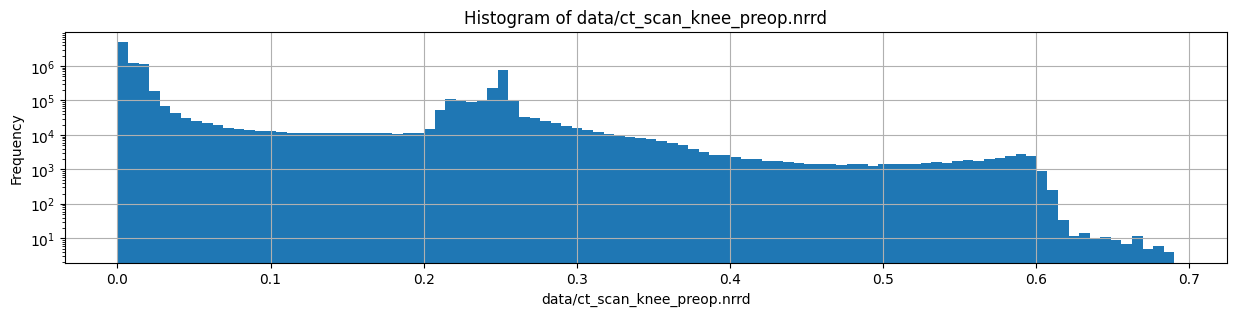

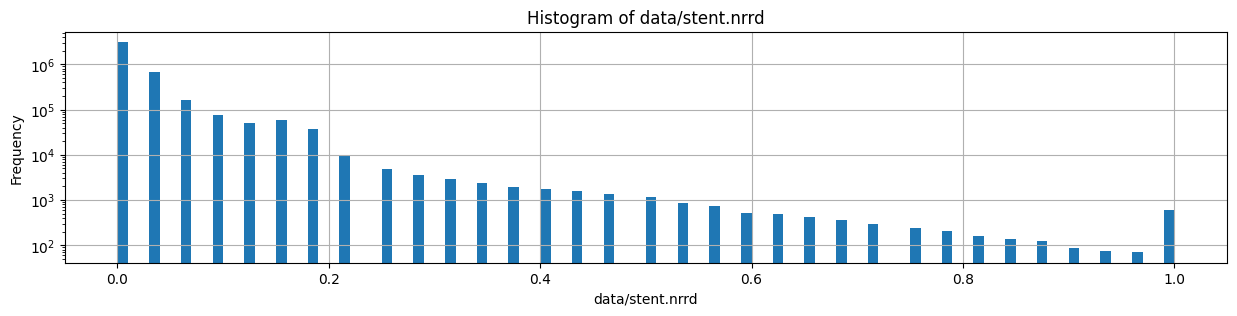

In [113]:
def plot_histogram_from_nrrd_file(filename):
    """Reads an NRRD file and plots a histogram of its data values."""
    data, _ = nrrd.read(filename)
    plot_histogram(data.ravel(), filename, tick_interval=None)

# Plot histograms for each dataset
plot_histogram_from_nrrd_file(filename_output_nrrd)
plot_histogram_from_nrrd_file(filename_stent_nrrd)


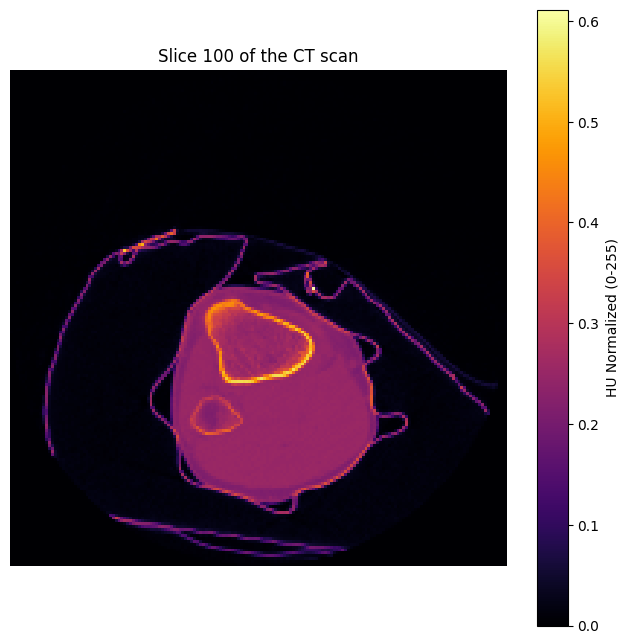

In [114]:
# Select the middle slice (or choose any slice you want)
slice_index = 100
slice_data = ct_data_scaled[slice_index, :, :]  # Select the slice

# Plot the slice
plt.figure(figsize=(8, 8))
plt.imshow(slice_data, cmap='inferno', interpolation='none')
plt.title(f'Slice {slice_index} of the CT scan')
plt.colorbar(label='HU Normalized (0-255)')
plt.axis('off')  # Hide axis
plt.show()
